# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [2]:
#%pip install tensorflow --upgrade
#%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from scipy import stats

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense,
    BatchNormalization, LeakyReLU, Dropout
)

%matplotlib inline

First, create some useful functions

In [3]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()

    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


In [5]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [6]:
#l0 = Input(shape=(height, width, 1), name='l0')
#l1 = Conv2D(2, (2, 2), padding='same', activation='relu', name='l1')(l0)
#l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)
#l2 = Conv2D(2, (2, 2), padding='same', activation='relu', name='l2')(l1_mp)
#l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)
#l3 = Conv2D(2, (2, 2), padding='same', activation='relu', name='l3')(l2_mp)
#l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)
#flat = Flatten(name='flat')(l3_mp)
#l4 = Dense(2, activation='relu', name='l4')(flat)
#l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

#l0 = Input(shape=(height, width, 1), name='l0')
#l1 = Conv2D(2, (3, 3), padding='same', activation='relu', name='l1')(l0)
#l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)
#flat = Flatten(name='flat')(l1_mp)
#l4 = Dense(8, activation='relu', name='l4')(flat)
#l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

l0 = Input(shape=(height, width, 1), name='l0')
l1 = Conv2D(4, (3, 3), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)
l2 = Conv2D(8, (3, 3), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)
flat = Flatten(name='flat')(l2_mp)
l4 = Dense(16, activation='relu', name='l4')(flat)
l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l0 (InputLayer)                 │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Conv2D)                     │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_mp (MaxPooling2D)            │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Conv2D)                     │ (None, 14, 14, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_mp (MaxPooling2D)            │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4 (Dense)                      │ (None, 16)             │         6,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l5 (Dense)                      │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,794 (26.54 KB)

 Trainable params: 6,794 (26.54 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train de CNN

In [7]:
batch_size = 128
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6200 - loss: 1.2797 - val_accuracy: 0.9322 - val_loss: 0.2321
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9271 - loss: 0.2479 - val_accuracy: 0.9675 - val_loss: 0.1233
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9523 - loss: 0.1569 - val_accuracy: 0.9717 - val_loss: 0.0982
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9648 - loss: 0.1155 - val_accuracy: 0.9738 - val_loss: 0.0891
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9706 - loss: 0.0962 - val_accuracy: 0.9787 - val_loss: 0.0770
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9737 - loss: 0.0890 - val_accuracy: 0.9792 - val_loss: 0.0681
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9767 - loss: 0.0748 - val_accuracy: 0.9803 - val_loss: 0.0686
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9780 - loss: 0.0698 - val_accuracy: 0.

Show the performance of the model

Test score: 0.05397616699337959
Test accuracy: 0.9848999977111816


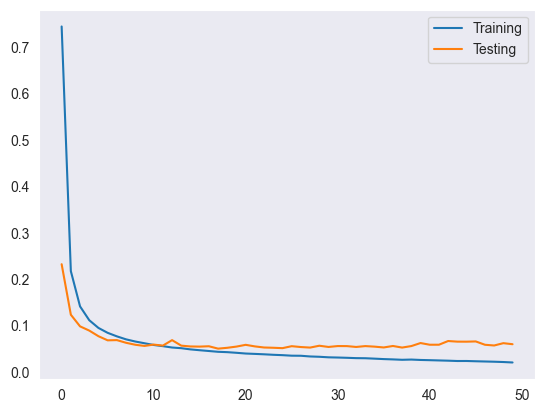

In [8]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
pred.shape =  (10000, 10)
F1 macro Score: 0.9847688175492827
F1 weighted Score: 0.9848936942322345
F1 micro Score: 0.9849


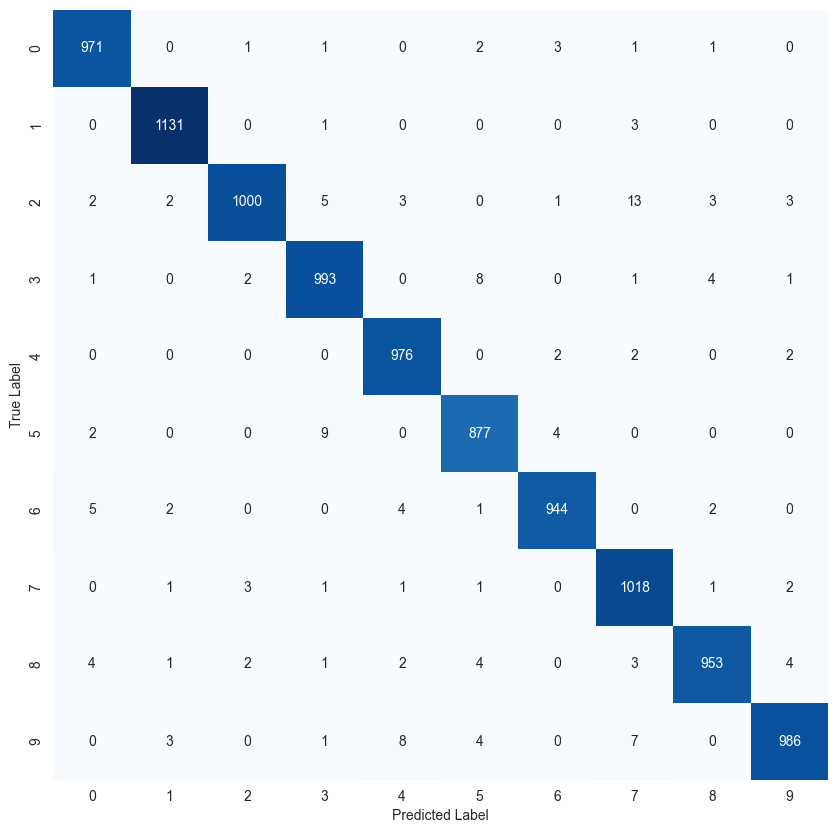

In [9]:
pred = model.predict(X_test)
print('pred.shape = ', pred.shape)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

f1_score_macro = f1_score(y_test, pred, average='macro')
f1_score_micro = f1_score(y_test, pred, average='micro')
f1_score_weighted = f1_score(y_test, pred, average='weighted')

print(f"F1 macro Score: {f1_score_macro}")
print(f"F1 weighted Score: {f1_score_weighted}")
print(f"F1 micro Score: {f1_score_micro}")